https://pytorch-forecasting.readthedocs.io/en/v1.2.0/tutorials/ar.html

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import lightning.pytorch as ptl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

# Suppress the weights_only warning for PyTorch Forecasting compatibility
import warnings
warnings.filterwarnings("ignore", message=".*weights_only.*")

# Add safe globals for PyTorch Forecasting (addresses PyTorch 2.6 weights_only warning)
import pytorch_forecasting
torch.serialization.add_safe_globals([pytorch_forecasting.data.encoders.TorchNormalizer])

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
from lightning.pytorch.tuner import Tuner

import plotly.graph_objects as go

In [3]:
torch.set_float32_matmul_precision('medium')
# torch.load(weights_only=True) 

In [4]:
# Device detection
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA available. Using GPU: {torch.cuda.get_device_name()}")
elif torch.backends.mps.is_available():  # For Apple Silicon Macs
    device = torch.device("mps") 
    print("MPS available. Using Apple Silicon GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Selected device: {device}")

CUDA available. Using GPU: NVIDIA GeForce RTX 5060 Ti
Selected device: cuda


In [5]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [6]:
data.tail()

,series,time_idx,value,static,date
39995,99,395,-5.587069,2,2021-01-30
39996,99,396,-4.986342,2,2021-01-31
39997,99,397,-5.630228,2,2021-02-01
39998,99,398,-5.745145,2,2021-02-02
39999,99,399,-4.690036,2,2021-02-03


In [7]:
fig = go.Figure()
for series_id in data["series"].unique():
    fig.add_trace(go.Scatter(x=data[data.series==series_id].time_idx, y=data[data.series==series_id].value, name=f"id={series_id}"))
fig.layout.showlegend = True
fig.show()

In [8]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [9]:
# calculate baseline absolute error
baseline_predictions = Baseline().to(device).predict(
    val_dataloader, 
    return_y=True,
    num_workers=12
    )
metric = SMAPE().to(device)

output = baseline_predictions.output.to(device)
y = baseline_predictions.y[0].to(device)

metric(output, y)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.5462, device='cuda:0')

In [10]:
# ptl.seed_everything(42)
# trainer = ptl.Trainer(
#     accelerator="auto", 
#     gradient_clip_val=0.01,
#     enable_checkpointing=False
#     )

# net = NBeats.from_dataset(
#     training, 
#     learning_rate=3e-2, 
#     weight_decay=1e-2, 
#     widths=[32, 512], 
#     backcast_loss_ratio=0.1
#     )
# turner = Tuner(trainer)
# # find optimal learning rate
# res = turner.lr_find(
#     net, 
#     train_dataloaders=train_dataloader, 
#     val_dataloaders=val_dataloader, 
#     min_lr=1e-5)

# print(f"suggested learning rate: {res.suggestion()}")


In [11]:

# # Plot the learning rate finder results
# fig = res.plot(show=True, suggest=True)
# fig.show()

# # Update the model with the suggested learning rate
# net.hparams.learning_rate = res.suggestion()
# print(f"Updated learning rate to: {net.hparams.learning_rate}")

In [12]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = ptl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss            | MASE       | 0      | train | 0    
1 | logging_metrics | ModuleList | 0      | train | 0    
2 | net_blocks      | ModuleList | 1.7 M  | train | 0    
---------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path


'/home/volody/code/study-py/ts-pytorch/Chapter_6/lightning_logs/version_46/checkpoints/epoch=2-step=450.ckpt'

In [14]:
best_model = NBeats.load_from_checkpoint(best_model_path, weights_only=False)

In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to("cpu")
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"))
(actuals - predictions).abs().mean()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


tensor(0.4743)

In [16]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


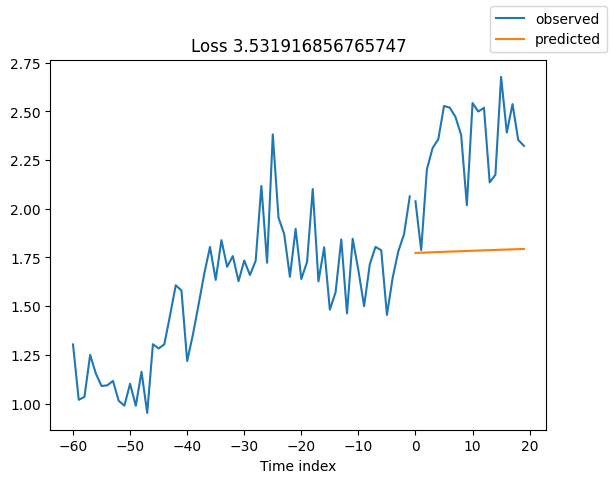

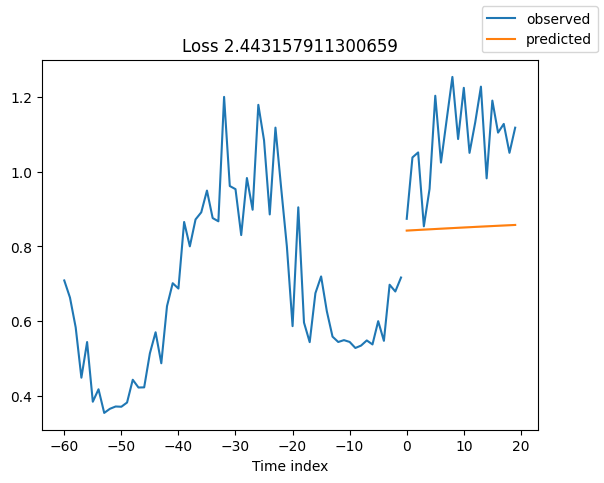

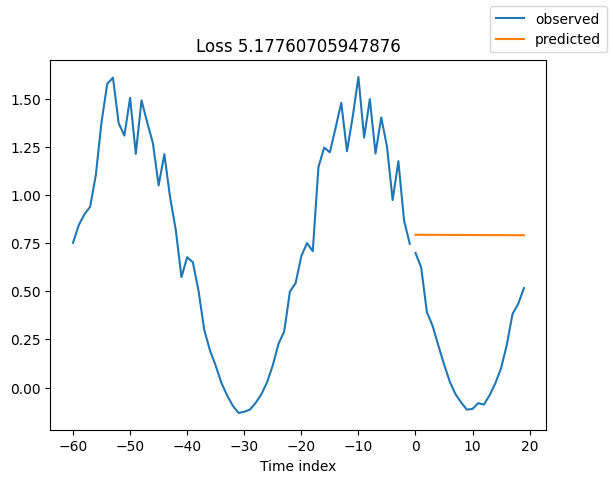

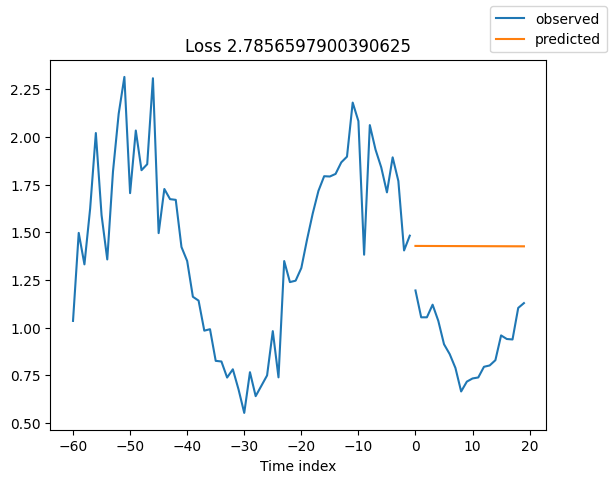

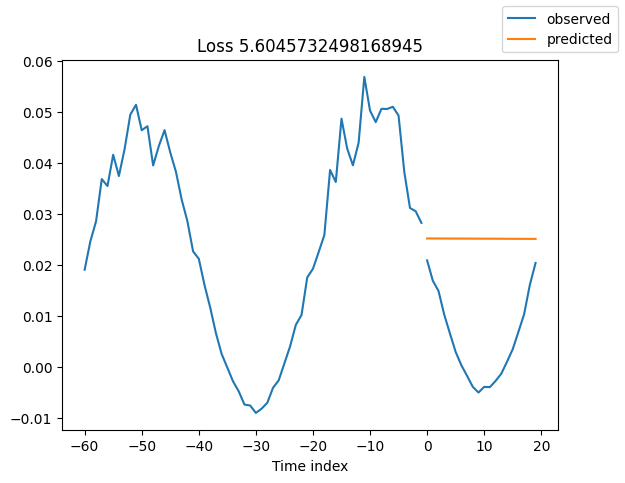

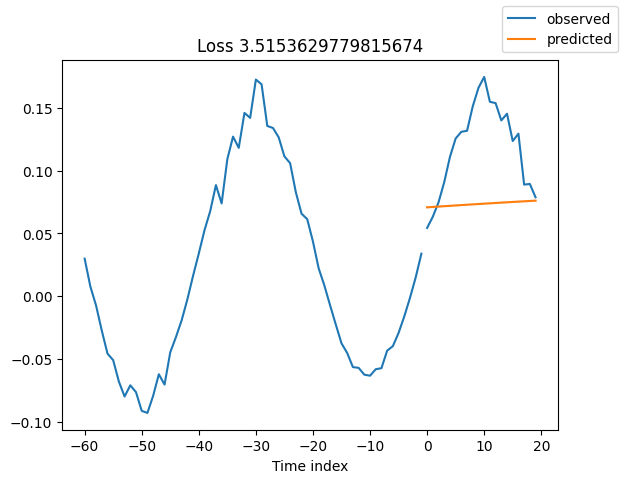

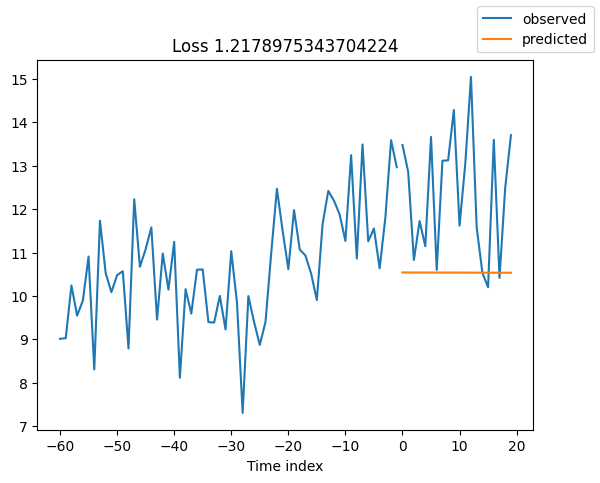

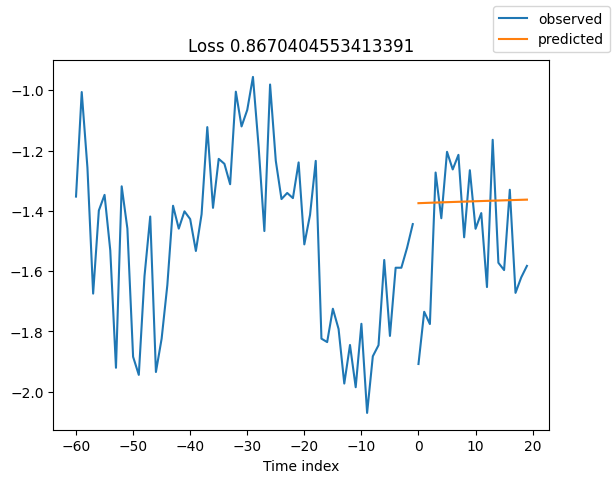

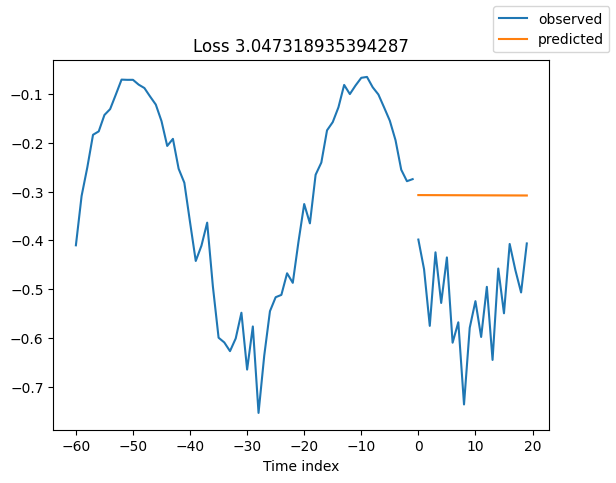

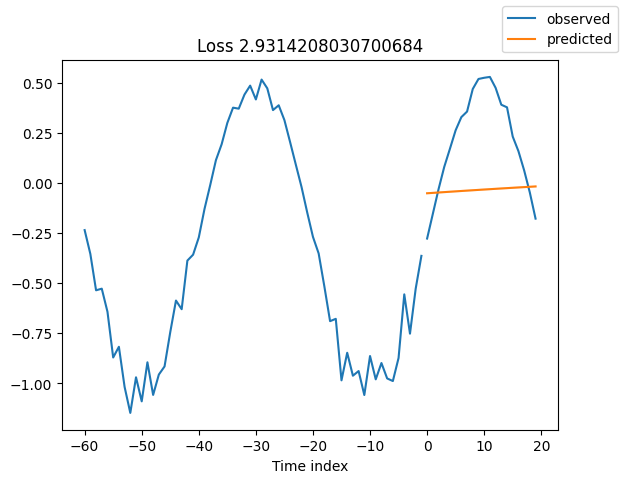

In [17]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)


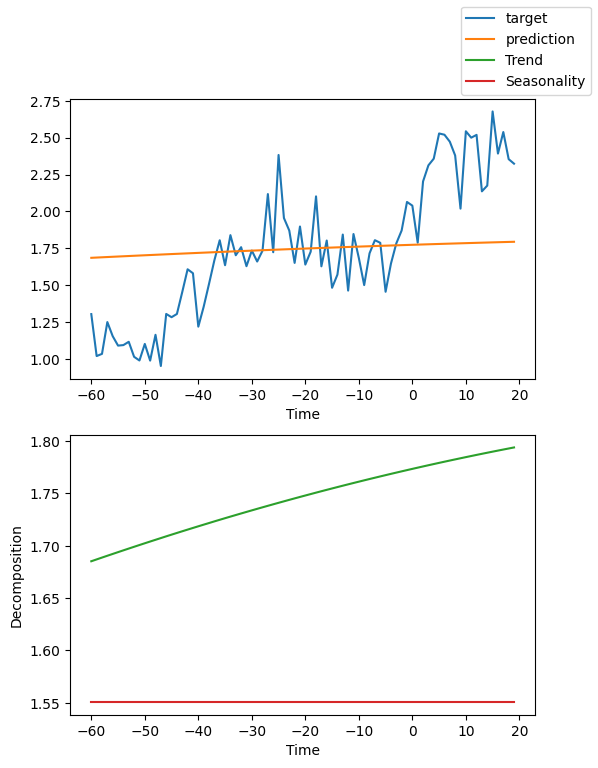

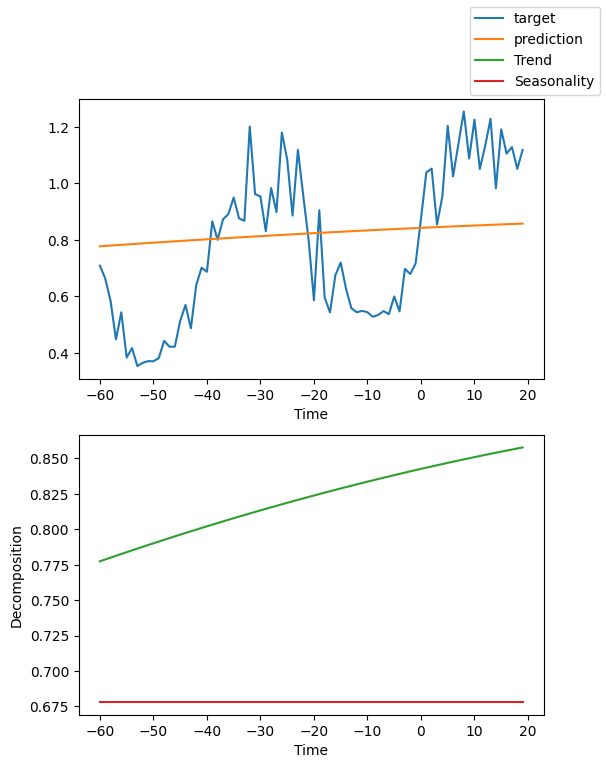

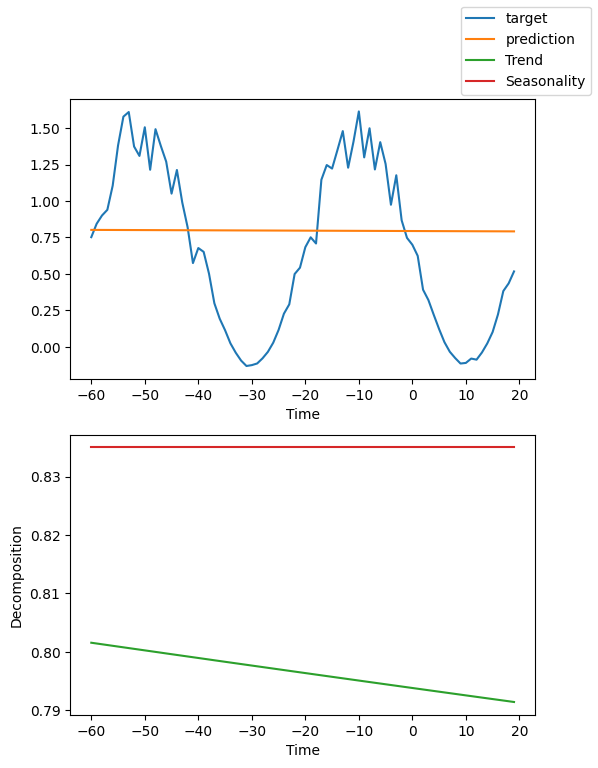

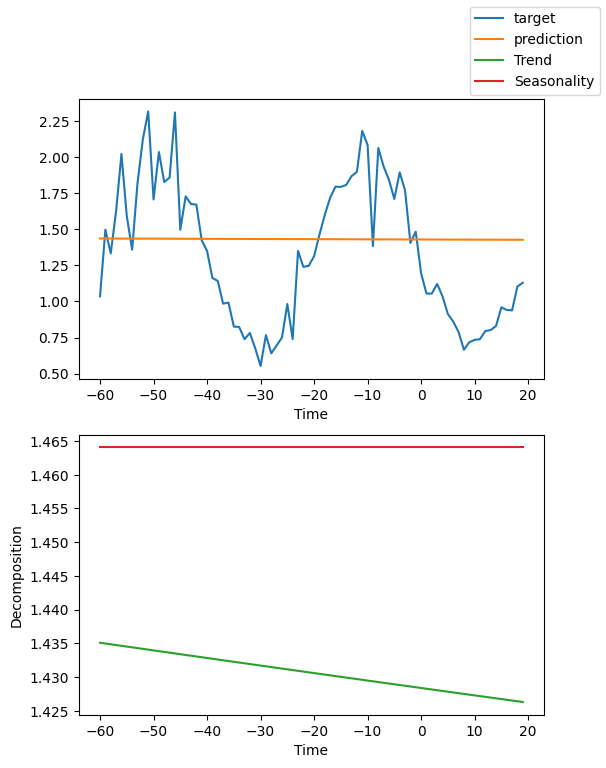

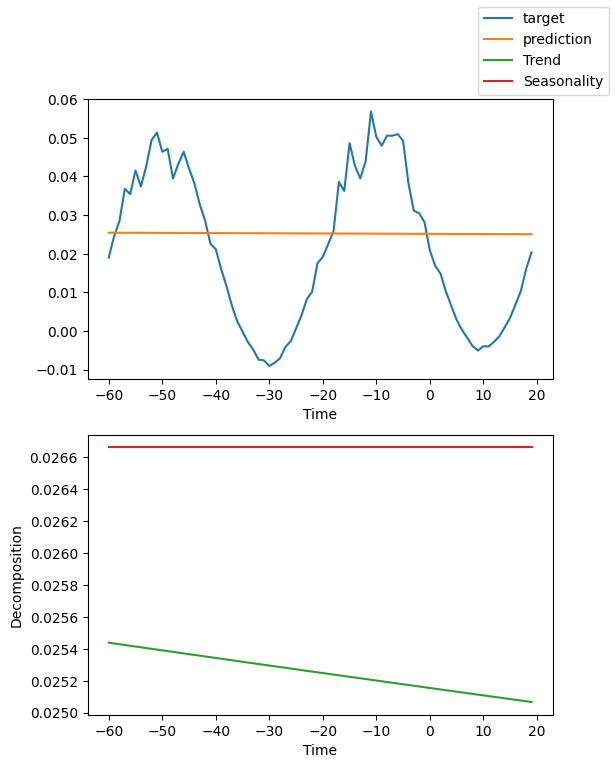

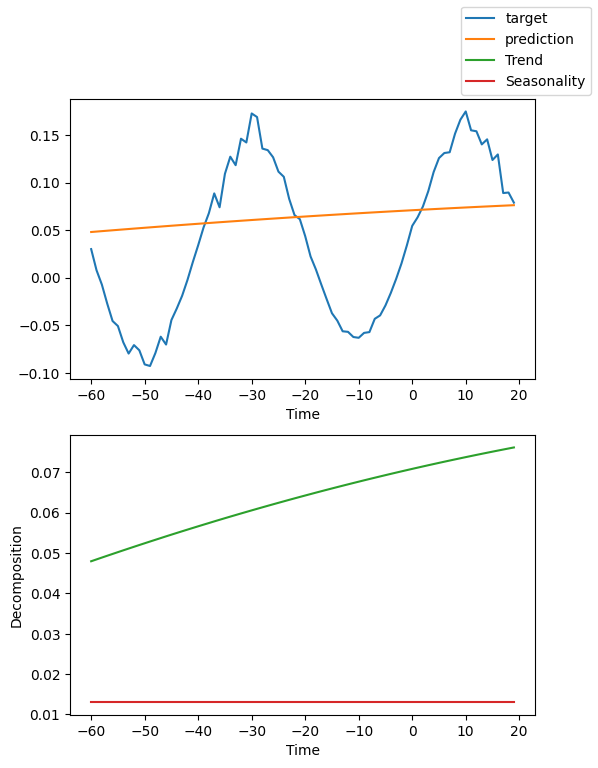

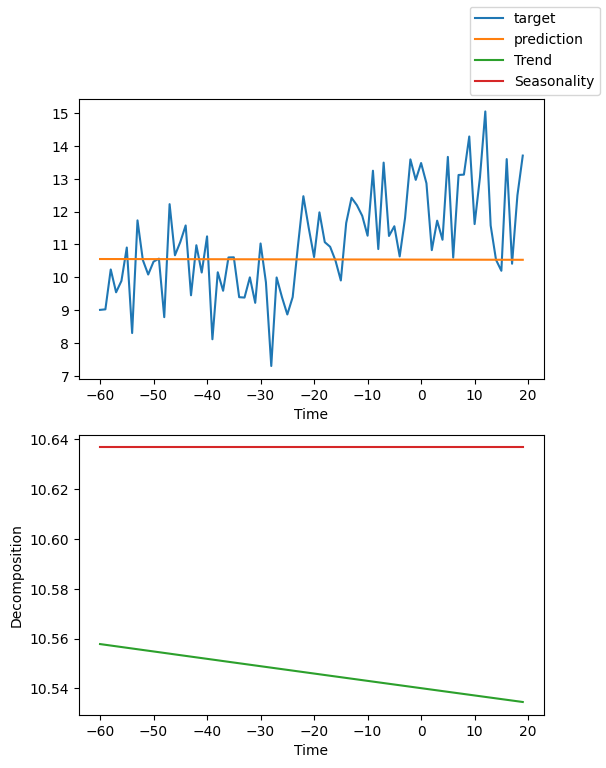

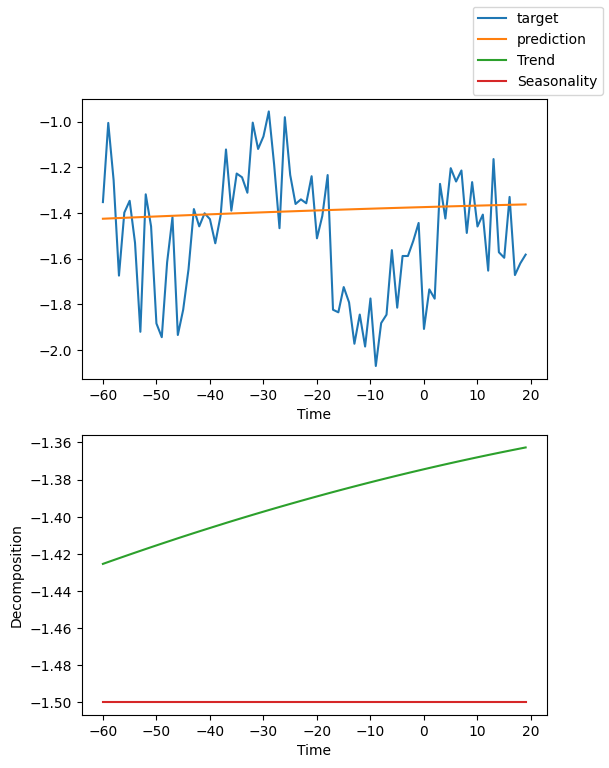

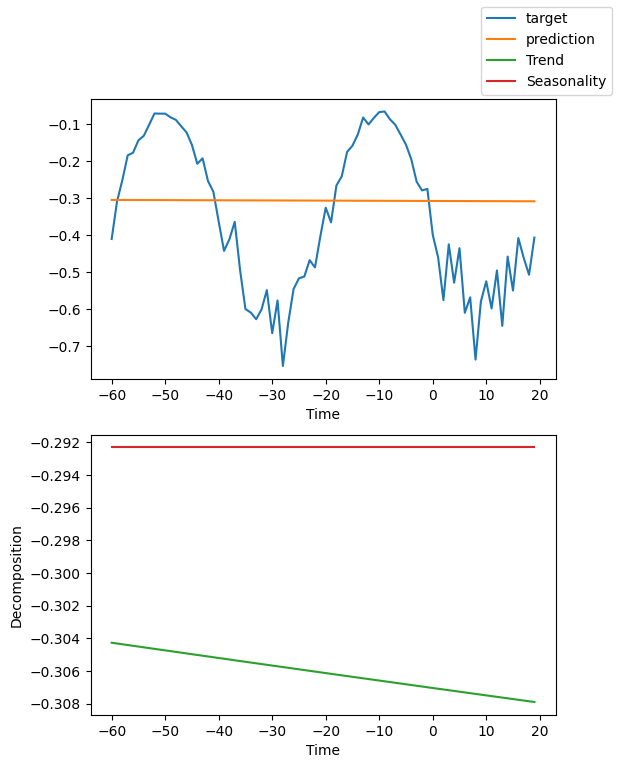

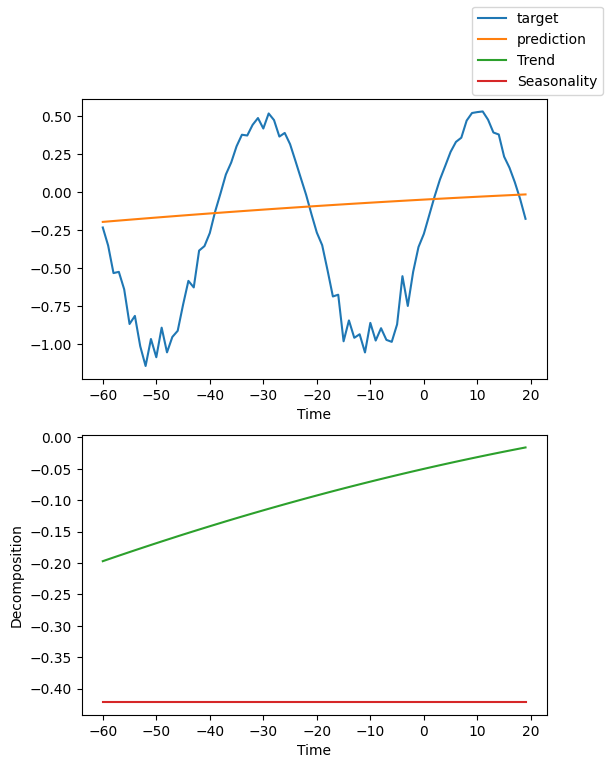

In [18]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)